## bert-base-uncased

L'ultimo modello non è tratto da Hugging Face, ma bensì si basa direttamente su BERT.

# Dataset

Rispetto ai due esempi precedenti, occorre modificare leggermente la classe RedditDataset

In [1]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import torch

class RedditDataset(Dataset):
  """
    La classe RedditDataset si occupa di rappresentare il dataset che viene usato per l'addestramento, occupandosi anche della divisione tra Train, Test e Validation
  """

  def __init__(self, data, tokenizer, split, max_length=128, scale = False):
    """
      Costruttore della classe, che si occupa di caricare il file indicato dal parametro csv_file.
      Inoltre divide il dataset in Train (80%), Test (10%) e Validation (10%).

      PARAMETRI:
      csv_file: percorso del file csv da caricare
      scale: se True aumenta di uno le label del dataset (default False)
    """
    data.dropna(inplace=True)

    if len(data) == 0:
      raise ValueError("Dataset vuoto")

    if scale:
      data["category"] = data["category"] + 1

    train, temp_data = train_test_split(data, test_size=0.2, stratify=data["category"], random_state=42)
    validation, test = train_test_split(temp_data, test_size=0.5, stratify=temp_data["category"], random_state=42)

    if split == 'train':
      selected_data = train
    elif split == 'validation':
      selected_data = validation
    elif split == 'test':
      selected_data = test
    else:
      raise ValueError("Il Parametro 'split' deve essere: 'train', 'validation' o 'test'")

    self.encodings = tokenizer(selected_data["clean_comment"].tolist(), truncation=True, padding=True, max_length=max_length)
    self.labels = selected_data["category"].tolist()

  def __getitem__(self, idx):
    item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    item['labels'] = torch.tensor(self.labels[idx])
    return item

  def __len__(self):
    return len(self.labels)


In [15]:
import torch
from transformers import BertForSequenceClassification, BertTokenizer
from torch.optim import AdamW
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

class SentimentClassifier:

  def __init__(self):
    self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    self.model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
    self.optimizer = AdamW(self.model.parameters(), lr=5e-5)

  def get_tokenizer(self):
    return self.tokenizer

  def prediction(self, text, device="cpu"):
    self.model.eval()
    self.model.to(device)
    with torch.no_grad():
        inputs = self.tokenizer(text, return_tensors="pt", padding=True, truncation=True)
        outputs = self.model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        print(f"Positive score: {predictions[0][1].item():.4f}")

  def evaluate(self, dataloader, device='cpu', confusion_matrix_path="bert-base-uncased", label_names=["Negativo", "Neutrale", "Positivo"], is_pre_finetuning=True):
    self.model.eval()
    self.model.to(device)

    predictions = []
    true_labels = []
    total_loss = 0.0
    total_steps = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()
            total_steps += 1

            preds = torch.argmax(logits, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / total_steps
    acc = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='weighted')
    cm = confusion_matrix(true_labels, predictions, normalize='true')
    report = classification_report(true_labels, predictions, digits=4)

    # Output
    print("Confusion Matrix:\n", cm)

     # Visualizzazione con heatmap
    if label_names is not None:
      plt.figure(figsize=(6, 5))
      sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
      plt.xlabel("Predetto")
      plt.ylabel("Reale")
      plt.title("Confusion Matrix")
      plt.tight_layout()
      suffix = '-prefinetuning' if is_pre_finetuning else '-finetuned'
      plt.savefig(f"{confusion_matrix_path}{suffix}.png")
      plt.show()

    print("\nClassification Report:\n", report)

    print(f"eval_loss: {avg_loss:.4f}")
    print(f"eval_accuracy: {acc:.4f}")
    print(f"eval_f1: {f1:.4f}")


  def train(self, dataloader, device="cpu", number_epoch=3):
    self.model.train()
    self.model.to(device)
    for epoch in range(number_epoch):
        for batch in dataloader:
            self.optimizer.zero_grad()

            # Move batch to device
            inputs = {k: v for k, v in batch.items() if k != 'labels'}
            labels = batch['labels']

            # Forward pass
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss # Loss is calculated internally by the model

            # Backward pass and optimize
            loss.backward()
            self.optimizer.step()

        print(f"Epoch {epoch+1}, Loss: {loss.item()}")

  def save(self, path):
    """
    Salva il modello e il tokenizer nel percorso specificato.

    Args:
        path (str): Directory in cui salvare il modello e il tokenizer.
    """

    self.model.save_pretrained(path)
    self.tokenizer.save_pretrained(path)
    print(f"Modello e tokenizer salvati in: {path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Statistiche pre-fine tuning:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix:
 [[0.         0.7267231  0.2732769 ]
 [0.         0.64597701 0.35402299]
 [0.         0.72078332 0.27921668]]


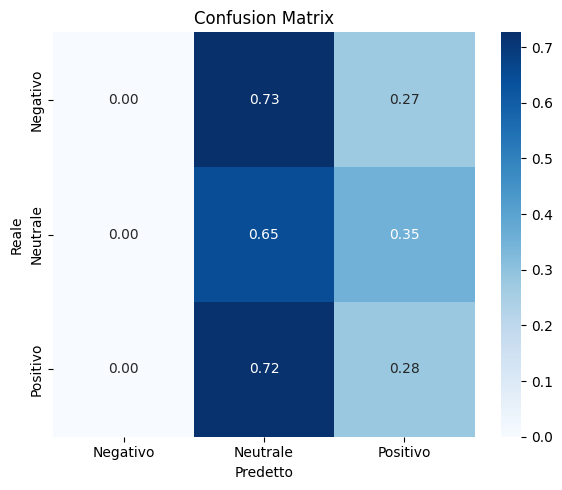


Classification Report:
               precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       827
           1     0.3261    0.6460    0.4334      1305
           2     0.3912    0.2792    0.3258      1583

    accuracy                         0.3459      3715
   macro avg     0.2391    0.3084    0.2531      3715
weighted avg     0.2812    0.3459    0.2911      3715

eval_loss: 1.0928
eval_accuracy: 0.3459
eval_f1: 0.2911
Inizio Adddestramento
Epoch 1, Loss: 0.03912630304694176
Epoch 2, Loss: 0.026668207719922066
Epoch 3, Loss: 0.02489292062819004
Fine Addestramento

Statistiche post-fine tuning:
Confusion Matrix:
 [[0.88029021 0.01813785 0.10157195]
 [0.01532567 0.95862069 0.02605364]
 [0.03979785 0.00821226 0.95198989]]


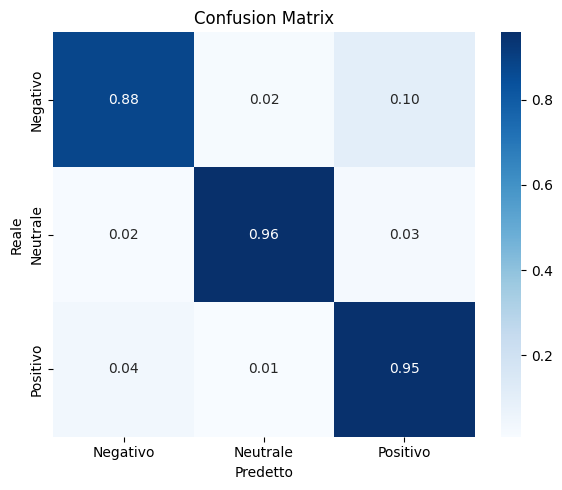


Classification Report:
               precision    recall  f1-score   support

           0     0.8977    0.8803    0.8889       827
           1     0.9781    0.9586    0.9683      1305
           2     0.9274    0.9520    0.9395      1583

    accuracy                         0.9384      3715
   macro avg     0.9344    0.9303    0.9322      3715
weighted avg     0.9386    0.9384    0.9383      3715

eval_loss: 0.2029
eval_accuracy: 0.9384
eval_f1: 0.9383

Statistiche Test:
Confusion Matrix:
 [[0.87077295 0.01811594 0.11111111]
 [0.01380368 0.96932515 0.01687117]
 [0.03600758 0.00568541 0.95830701]]


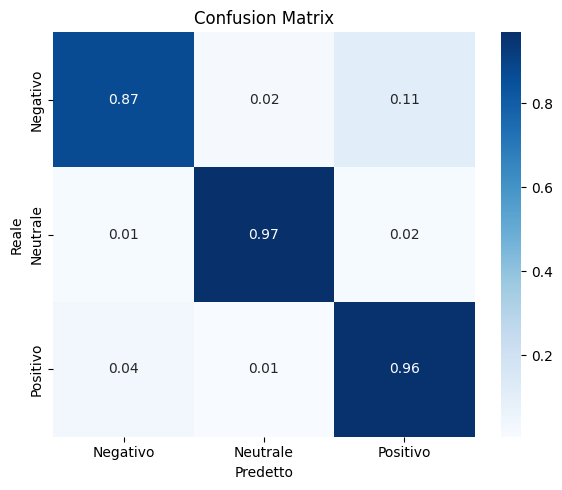


Classification Report:
               precision    recall  f1-score   support

           0     0.9058    0.8708    0.8879       828
           1     0.9814    0.9693    0.9753      1304
           2     0.9301    0.9583    0.9440      1583

    accuracy                         0.9427      3715
   macro avg     0.9391    0.9328    0.9357      3715
weighted avg     0.9427    0.9427    0.9425      3715

eval_loss: 0.1804
eval_accuracy: 0.9427
eval_f1: 0.9425
Modello e tokenizer salvati in: /content/drive/MyDrive/bert-base-uncased


In [16]:
from google.colab import drive
drive.mount('/content/drive') #Per il salvataggio all'interno di Google Drive

import pandas as pd

data = pd.read_csv("./Reddit_Data.csv", on_bad_lines='skip')
classifier = SentimentClassifier()

device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

train_dataset = RedditDataset(data, classifier.get_tokenizer(), split="train", scale=True)
evaluetion_dataset = RedditDataset(data, classifier.get_tokenizer(), split="validation")
test_dataset = RedditDataset(data, classifier.get_tokenizer(), split="test")

print("Statistiche pre-fine tuning:")

val_dataloader = DataLoader(evaluetion_dataset, batch_size=8)
classifier.evaluate(val_dataloader, device=device, confusion_matrix_path="bert-base-uncased", is_pre_finetuning=True)

print("Inizio Adddestramento")
train_dataloader = DataLoader(train_dataset, batch_size=8)
classifier.train(train_dataloader, device=device)
print("Fine Addestramento")

print("\nStatistiche post-fine tuning:")
val_dataloader = DataLoader(evaluetion_dataset, batch_size=8)
classifier.evaluate(val_dataloader, device=device, confusion_matrix_path="bert-base-uncased", is_pre_finetuning=False)

print("\nStatistiche Test:")
test_dataloader = DataLoader(test_dataset, batch_size=8)
classifier.evaluate(test_dataloader, device=device, confusion_matrix_path="bert-base-uncased-test")

classifier.save("/content/drive/MyDrive/bert-base-uncased")

